#**Autoencoder Model for Word Embedding**

#I. Import necessary things

In [30]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import re
import os
import pickle
import nltk
import numpy as np
from scipy.spatial import distance

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#II. Load corpus and preprocess it

In [2]:
# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")
    
train_data = load_data("Corona_NLP_train.csv").iloc[:2000]

corpus = train_data["OriginalTweet"].to_list()
corpus = "\n".join(corpus)
print(corpus[:1000])

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j


Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes s


In [3]:
def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub(r"'s\b","",text)
    # remove punctuations
    text = re.sub("[^a-zA-Z]", " ", text)
    return text

In [4]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def preprocess_text(corpus):
  corpus_clean = text_cleaner(corpus)

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(corpus_clean)
  
  return [w for w in word_tokens if not w in stop_words]

corpus_token =  preprocess_text(corpus)
print(corpus_token)

['menyrbie', 'phil', 'gahan', 'chrisitv', 'https', 'co', 'ifz', 'fan', 'pa', 'https', 'co', 'xx', 'ghgfzcc', 'https', 'co', 'nlzdxno', 'advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order', 'coronavirus', 'australia', 'woolworths', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid', 'outbreak', 'https', 'co', 'binca', 'vp', 'p', 'food', 'stock', 'one', 'empty', 'please', 'panic', 'enough', 'food', 'everyone', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covid', 'france', 'covid', 'covid', 'coronavirus', 'confinement', 'confinementotal', 'confinementgeneral', 'https', 'co', 'zrlg', 'z', 'j', 'ready', 'go', 'supermarket', 'covid', 'outbreak', 'paranoid', 'food', 'stock', 'litteraly', 'empty', 'coronavirus', 'serious', 'thing', 'please'

In [32]:
dictionary = sorted(list(set(corpus_token)))

if os.path.exists("mapping.pkl"):
  print("Load mapping")
  mapping = pickle.load(open("mapping.pkl", "rb"))
else:
  print("Save mapping")
  mapping = dict((c, i) for i, c in enumerate(dictionary))
  pickle.dump(mapping, open("mapping.pkl", "wb"))

print(dictionary)

Load mapping
['aa', 'aacounty', 'aagbwjm', 'ab', 'abandons', 'abate', 'abating', 'abbott', 'abc', 'abcactionnews', 'abidsuleri', 'abilene', 'ability', 'abl', 'able', 'abled', 'abou', 'abrir', 'abroad', 'abrupt', 'absolute', 'absolutely', 'absurd', 'abt', 'abuelos', 'abundance', 'abundant', 'abused', 'ac', 'aca', 'accc', 'acccgovau', 'accelerant', 'accelerated', 'accelerates', 'accelerating', 'accept', 'acceptable', 'accepting', 'access', 'accessible', 'accidentally', 'accommodate', 'accommodation', 'accommodations', 'according', 'accordingly', 'account', 'accountant', 'accounts', 'accumulation', 'accurate', 'accuse', 'accused', 'acejointhealth', 'aceli', 'ach', 'acquaintance', 'acquired', 'acquiring', 'acquisti', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activated', 'activates', 'activating', 'active', 'actively', 'activities', 'activity', 'actsofkindness', 'actual', 'actually', 'actuallyautistic', 'ad', 'adapt', 'adapting', 'adara', 'add', 'added', 'addiction', 'adding

#III. Convert corpus to one-hot vectors & Define embedding dim

In [6]:
embedding_dim = 256
vocab_size = len(dictionary)
print(vocab_size)

9382


In [7]:
corpus_encode = [mapping[x] for x in corpus_token]
onehot_corpus = keras.utils.to_categorical(corpus_encode, num_classes=vocab_size)
print(onehot_corpus)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#IV. Define Autoencoder model

In [33]:
ae_model = keras.Sequential()
ae_model.add(keras.Input(shape=(vocab_size,)))
ae_model.add(keras.layers.Dense(embedding_dim, activation='relu'))
ae_model.add(keras.layers.Dense(vocab_size, activation='softmax'))

ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

if os.path.exists("ae_model.h5"):
  ae_model.load_weights("ae_model.h5")

ae_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               2402048   
_________________________________________________________________
dense_3 (Dense)              (None, 9382)              2411174   
Total params: 4,813,222
Trainable params: 4,813,222
Non-trainable params: 0
_________________________________________________________________


#V. Train AE model

In [13]:
# Train model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ae_model.h5", monitor='val_loss', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

ae_model.fit(x=onehot_corpus, y=onehot_corpus, batch_size=512, epochs=1000,
          validation_split=0.2, validation_freq=1, shuffle=True,
          callbacks=[checkpoint_cb, early_stopping_cb],
          workers=1, use_multiprocessing=False)

ae_model.save("ae_model.h5")

#=======================================================================

# **How to use trained model**

#=======================================================================

#VI. Load trained model & Get output of 1st FC layer

In [14]:
reconstructed_model = keras.models.load_model("ae_model.h5")
we_model = keras.models.Model(inputs=reconstructed_model.inputs, outputs=reconstructed_model.get_layer('dense').output)

Define function to encode one-hot list of words

In [15]:
def encode_onehot(mapping, list_words):
  output = []
  
  for word in list_words:
    word_vector = [0 for _ in range(vocab_size)]

    if word in mapping.keys():
      word_index = mapping[word]
      word_vector[word_index] = 1
    
    output.append(word_vector)
  
  return output

#VII. Test model

In [17]:
input_sentence = "Covid is very dangerous"

preprocess_sentence = preprocess_text(input_sentence)
onehot_sentence = encode_onehot(mapping, preprocess_sentence)

embedded_sentence = we_model.predict(onehot_sentence)
print(embedded_sentence)

[[4.06475604e-01 5.56666851e-01 8.91694844e-01 2.02409774e-01
  3.63561720e-01 9.47227597e-01 9.66078043e-01 7.19983518e-01
  9.50620890e-01 8.05574179e-01 1.19232893e+00 1.54464230e-01
  1.01174271e+00 3.58965695e-02 9.04547036e-01 8.56472492e-01
  9.12031174e-01 7.15716720e-01 9.84351635e-01 6.11382961e-01
  9.18620169e-01 3.03476721e-01 1.04164648e+00 8.19975734e-01
  1.08274245e+00 6.26118302e-01 6.07103527e-01 3.92464995e-02
  1.06480646e+00 6.93634629e-01 9.60175157e-01 8.94799829e-02
  1.07960498e+00 1.00849628e+00 1.83866620e-02 2.24573612e-02
  3.42084050e-01 6.32417798e-01 8.56337786e-01 9.14180577e-01
  9.82545733e-01 9.13429320e-01 9.16496396e-01 8.22675824e-02
  9.43415582e-01 9.42817450e-01 9.53236103e-01 4.50155824e-01
  6.53574824e-01 9.11246538e-01 5.51844597e-01 8.67271423e-02
  1.32922649e+00 8.68343353e-01 1.28739387e-01 8.13623071e-02
  9.20582891e-01 4.19414341e-02 9.43308115e-01 8.70603144e-01
  2.42369175e-02 9.47394967e-01 4.23419476e-02 9.36237097e-01
  9.1060

In [20]:
word_0 = "virus"
word_1 = "vaccines"
word_2 = "playing"

preprocess_words = preprocess_text(' '.join([word_0, word_1, word_2]))
onehot_words = encode_onehot(mapping, preprocess_words)

word_0_eb, word_1_eb, word_2_eb = we_model.predict(onehot_words)

# print("OUTPUT EMBEDDING")
# print(word_0_eb)
# print(word_1_eb)
# print(word_2_eb)

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

OUTPUT DISTANCE
0 vs 1:  7.18173360824585
1 vs 2:  6.301677227020264
2 vs 0:  7.036297798156738


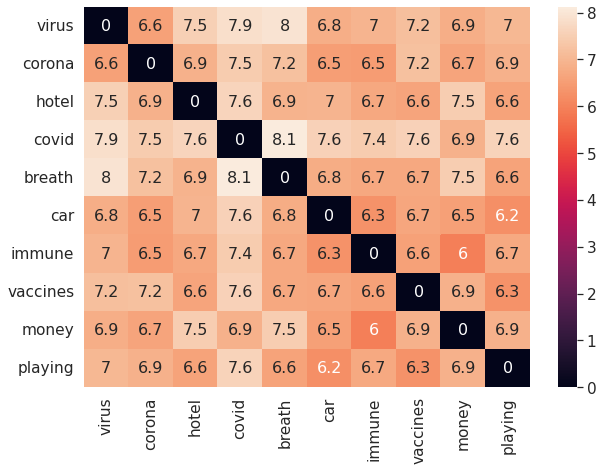

In [25]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["virus", "corona", "hotel", "covid", "breath", "car", "immune", "vaccines", "money", "playing"]
onehot_words = encode_onehot(mapping, list_words)
list_word_embs = we_model.predict(onehot_words)

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()